In [1]:
import math
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import xgboost as xgb
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# **Data inspection and preprocessing**

In [3]:
# Unpacking data from pickle file and basic information about the data
data = pd.read_pickle('./ass2.pickle')
train, dev, test = data['train'], data['dev'], data['test']

In [4]:
# Show basic data information
print(f"number of features: {len(train.columns) - 1}")
print(f"types of labels: {train['target'].unique()}")
print(f"number of different values: {[(c,len(train[c].unique()))  for c in train]}")
print(f"number of rows in train: {len(train)}")
print(f"number of rows in dev: {len(dev)}")
print(f"number of rows in test: {len(test)}")


number of features: 42
types of labels: [2 1 0]
number of different values: [('f0', 3), ('f1', 3), ('f2', 3), ('f3', 3), ('f4', 3), ('f5', 3), ('f6', 3), ('f7', 3), ('f8', 3), ('f9', 3), ('f10', 3), ('f11', 3), ('f12', 3), ('f13', 3), ('f14', 3), ('f15', 3), ('f16', 3), ('f17', 3), ('f18', 3), ('f19', 3), ('f20', 3), ('f21', 3), ('f22', 3), ('f23', 3), ('f24', 3), ('f25', 3), ('f26', 3), ('f27', 3), ('f28', 3), ('f29', 3), ('f30', 3), ('f31', 3), ('f32', 3), ('f33', 3), ('f34', 3), ('f35', 3), ('f36', 3), ('f37', 3), ('f38', 3), ('f39', 3), ('f40', 3), ('f41', 3), ('target', 3)]
number of rows in train: 40533
number of rows in dev: 13512
number of rows in test: 13512


In [ ]:
#Checking for missing values
train.isnull().sum()

f0        0
f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
f7        0
f8        0
f9        0
f10       0
f11       0
f12       0
f13       0
f14       0
f15       0
f16       0
f17       0
f18       0
f19       0
f20       0
f21       0
f22       0
f23       0
f24       0
f25       0
f26       0
f27       0
f28       0
f29       0
f30       0
f31       0
f32       0
f33       0
f34       0
f35       0
f36       0
f37       0
f38       0
f39       0
f40       0
f41       0
target    0
dtype: int64

There are no missing values

In [ ]:
# Show general information about the data (mean, ste, etc. by feature)
train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f33,f34,f35,f36,f37,f38,f39,f40,f41,target
count,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,...,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000,40533.000000
mean,0.959539,0.540054,0.270890,0.131745,0.051982,0.009844,1.064269,0.582982,0.288407,0.137912,...,0.059260,0.014877,0.001604,0.838749,0.427331,0.188587,0.069992,0.016036,0.001406,1.562924
std,0.834109,0.779471,0.612657,0.448263,0.290031,0.119114,0.838151,0.793958,0.627516,0.457701,...,0.303588,0.152614,0.046832,0.832101,0.724840,0.525442,0.330019,0.155936,0.042993,0.662817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
# Information about the training data - group by label
train.groupby('target').describe()

f0                                                    f1  \
          count      mean       std  min  25%  50%  75%  max    count   
target                                                                  
0        3917.0  1.061527  0.833138  0.0  0.0  1.0  2.0  2.0   3917.0   
1        9882.0  1.082676  0.908831  0.0  0.0  1.0  2.0  2.0   9882.0   
2       26734.0  0.899080  0.798188  0.0  0.0  1.0  2.0  2.0  26734.0   

                  ...  f40           f41                                     \
            mean  ...  75%  max    count      mean       std  min  25%  50%   
target            ...                                                         
0       0.669135  ...  0.0  2.0   3917.0  0.003574  0.074868  0.0  0.0  0.0   
1       0.572759  ...  0.0  2.0   9882.0  0.000911  0.038952  0.0  0.0  0.0   
2       0.509052  ...  0.0  2.0  26734.0  0.001272  0.037681  0.0  0.0  0.0   

                  
        75%  max  
target            
0       0.0  2.0  
1       0.0  2.0  
2       0.0  2.0  

[3 rows x 336 columns]

the "count" column tells us that the data is unbalanced. There are way more samples of label "2" than the other labels.

In [5]:
# Splitting the data into features and labels dataframes
train_features, train_labels = train.drop('target', axis=1), train['target']
dev_features, dev_labels = dev.drop('target', axis=1), dev['target']
test_features, test_labels = test.drop('target', axis=1), test['target']

<Axes: >

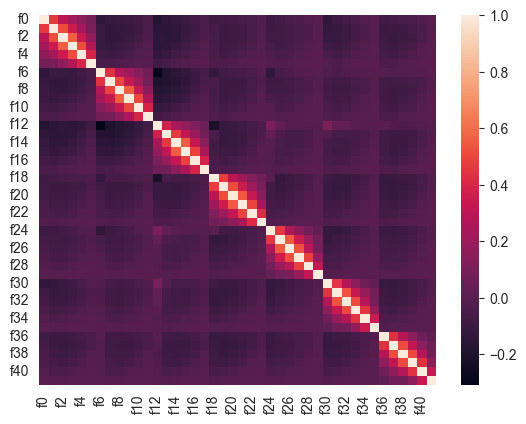

In [ ]:
# Check for redundant feature. We decide against removing features since the correlations are not strong enough
sns.heatmap(train_features.corr())

For each pipeline in the learning section, we apply preprocessing method using PowerTransformer to map the features into more normal distribustion (Gaussian) and make learning easier. We showed the statistical data of each feature (for example, the mean of it), and it implies that this preprocess will achieve better results.

In [ ]:
# After preprocess, features will be closer to form of Gaussian distribution
processed = PowerTransformer(method="yeo-johnson").fit(train_features).transform(train_features)
pd.DataFrame(processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
count,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,...,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04,4.053300e+04
mean,9.676550e-17,1.262159e-17,7.669367e-17,2.804797e-18,-4.347435e-17,-3.260577e-17,-7.047053e-17,-2.664557e-17,6.188083e-17,5.434294e-18,...,-1.116660e-16,1.332279e-17,-3.137867e-17,1.752998e-17,-6.310793e-17,-4.207196e-18,-4.654210e-17,-8.519571e-17,4.207196e-17,1.849413e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.200979e+00,-7.467845e-01,-4.716368e-01,-3.115412e-01,-1.892139e-01,-8.764691e-02,-1.293499e+00,-7.920003e-01,-4.907926e-01,-3.194826e-01,...,-3.487365e-01,-2.069069e-01,-1.033053e-01,-3.618409e-02,-1.073533e+00,-6.336377e-01,-3.815101e-01,-2.247513e-01,-1.091253e-01,-3.443290e-02
25%,-1.200979e+00,-7.467845e-01,-4.716368e-01,-3.115412e-01,-1.892139e-01,-8.764691e-02,-1.293499e+00,-7.920003e-01,-4.907926e-01,-3.194826e-01,...,-3.487365e-01,-2.069069e-01,-1.033053e-01,-3.618409e-02,-1.073533e+00,-6.336377e-01,-3.815101e-01,-2.247513e-01,-1.091253e-01,-3.443290e-02
50%,1.826660e-01,-7.467845e-01,-4.716368e-01,-3.115412e-01,-1.892139e-01,-8.764691e-02,-2.308405e-02,-7.920003e-01,-4.907926e-01,-3.194826e-01,...,-3.487365e-01,-2.069069e-01,-1.033053e-01,-3.618409e-02,4.329313e-01,-6.336377e-01,-3.815101e-01,-2.247513e-01,-1.091253e-01,-3.443290e-02
75%,1.180611e+00,1.154175e+00,-4.716368e-01,-3.115412e-01,-1.892139e-01,-8.764691e-02,1.095390e+00,1.038870e+00,-4.907926e-01,-3.194826e-01,...,-3.487365e-01,-2.069069e-01,-1.033053e-01,-3.618409e-02,1.257282e+00,1.481827e+00,-3.815101e-01,-2.247513e-01,-1.091253e-01,-3.443290e-02
max,1.180611e+00,1.496873e+00,2.140185e+00,3.210122e+00,5.285024e+00,1.140942e+01,1.095390e+00,1.447554e+00,2.063338e+00,3.130460e+00,...,2.868788e+00,4.833092e+00,9.680045e+00,2.763645e+01,1.257282e+00,1.670652e+00,2.624580e+00,4.449362e+00,9.163779e+00,2.904200e+01


# **Learning**

We try few models, and for each one we try different hyperparameters using grid search. Finally we use accuracy score metric to evaluate the model, and also show the confusion matrix

In [10]:
# Check XG Boost
# We try various learning rates and estimators
pipe = Pipeline(steps=[('scalar', PowerTransformer(method='yeo-johnson')), ('classifier', xgb.XGBClassifier(objective='multi:softmax', num_class=3))])
xg_param_space = [{'classifier__learning_rate': [0.2, 0.3, 0.4],
                 'classifier__n_estimators': [50, 100, 200]}]
xg_clf = GridSearchCV(pipe, xg_param_space, verbose=5)
xg_clf.fit(train_features, train_labels)
y_pred = xg_clf.predict(dev_features)
print(xg_clf.best_estimator_)
print("Accuracy:", metrics.accuracy_score(dev_labels, y_pred))
confusion_matrix(y_true=dev_labels, y_pred=y_pred, labels=[0,1,2])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__learning_rate=0.2, classifier__n_estimators=50;, score=0.796 total time=   2.4s
[CV 2/5] END classifier__learning_rate=0.2, classifier__n_estimators=50;, score=0.800 total time=   2.2s
[CV 3/5] END classifier__learning_rate=0.2, classifier__n_estimators=50;, score=0.792 total time=   2.2s
[CV 4/5] END classifier__learning_rate=0.2, classifier__n_estimators=50;, score=0.791 total time=   4.6s
[CV 5/5] END classifier__learning_rate=0.2, classifier__n_estimators=50;, score=0.800 total time=   2.2s
[CV 1/5] END classifier__learning_rate=0.2, classifier__n_estimators=100;, score=0.812 total time=   2.9s
[CV 2/5] END classifier__learning_rate=0.2, classifier__n_estimators=100;, score=0.815 total time=   3.0s
[CV 3/5] END classifier__learning_rate=0.2, classifier__n_estimators=100;, score=0.811 total time=   9.3s
[CV 4/5] END classifier__learning_rate=0.2, classifier__n_estimators=100;, score=0.809 total time

array([[ 340,  359,  571],
       [ 149, 2690,  534],
       [ 151,  340, 8378]])

In [6]:
# Check Random Forest
# We try various depth and minimal split parameters
pipe = Pipeline(steps=[('scalar', PowerTransformer(method='yeo-johnson')), ('classifier', RandomForestClassifier())])
forest_param_space = [{'classifier__n_estimators': [50, 100, 200],
                 'classifier__max_depth': [None, 30, 50],
                 'classifier__min_samples_split': [2, 3, 4]}]
rf_clf = GridSearchCV(pipe, forest_param_space, verbose=5)
rf_clf.fit(train_features, train_labels)
y_pred = rf_clf.predict(dev_features)
print(rf_clf.best_estimator_)
print("Accuracy:", metrics.accuracy_score(dev_labels, y_pred))
confusion_matrix(y_true=dev_labels, y_pred=y_pred, labels=[0,1,2])

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.787 total time=   3.6s
[CV 2/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.794 total time=   4.2s
[CV 3/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.788 total time=   5.2s
[CV 4/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.789 total time=   3.6s
[CV 5/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.790 total time=   3.5s
[CV 1/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.792 total time=   6.7s
[CV 2/5] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.795 total time

array([[ 110,  321,  839],
       [  61, 2226, 1086],
       [  63,  309, 8497]])

In [7]:
# Check Gradient Boosting
# We try various hyperparameters for this model as well
pipe = Pipeline(steps=[('scalar', PowerTransformer(method='yeo-johnson')), ('classifier', GradientBoostingClassifier())])
gb_param_space = [{'classifier__learning_rate': [0.2, 0.3],
                 'classifier__max_depth': [2, 3],
                 'classifier__min_samples_split': [2, 3],
                 'classifier__n_estimators': [50, 100]}]
gb_clf = GridSearchCV(pipe, gb_param_space, verbose=5)
gb_clf.fit(train_features, train_labels)
y_pred = gb_clf.predict(dev_features)
print(gb_clf.best_estimator_)
print("Accuracy:", metrics.accuracy_score(dev_labels, y_pred))
confusion_matrix(y_true=dev_labels, y_pred=y_pred, labels=[0,1,2])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.728 total time=   7.5s
[CV 2/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.721 total time=   7.3s
[CV 3/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.718 total time=   6.2s
[CV 4/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.721 total time=   7.2s
[CV 5/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimators=50;, score=0.719 total time=   6.3s
[CV 1/5] END classifier__learning_rate=0.2, classifier__max_depth=2, classifier__min_samples_split=2, classifier__n_estimato

array([[  51,  329,  890],
       [  33, 2160, 1180],
       [  15,  495, 8359]])

We note that we tried using PolynomialFeatures for XG boost and gradient boosting, but it caused our models to perform extremely slow and didn't achieve better results.

In [12]:
# Check SVC
# We try few possible parameters
pipe = Pipeline(steps=[('scalar', PowerTransformer(method='yeo-johnson')),('classifier', SVC(gamma='auto'))])
svc_param_space = [{'classifier__class_weight': [None, 'balanced'], 'classifier__C': [2, 3]}]
svc_clf = GridSearchCV(pipe, svc_param_space, verbose=5)
svc_clf.fit(train_features, train_labels)
y_pred = svc_clf.predict(dev_features)
print(svc_clf.best_estimator_)
print("Accuracy:", metrics.accuracy_score(dev_labels, y_pred))
confusion_matrix(y_true=dev_labels, y_pred=y_pred, labels=[0,1,2])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier__C=2, classifier__class_weight=None;, score=0.703 total time= 3.2min
[CV 2/5] END classifier__C=2, classifier__class_weight=None;, score=0.698 total time= 3.1min
[CV 3/5] END classifier__C=2, classifier__class_weight=None;, score=0.701 total time= 2.8min
[CV 4/5] END classifier__C=2, classifier__class_weight=None;, score=0.700 total time= 2.8min
[CV 5/5] END classifier__C=2, classifier__class_weight=None;, score=0.701 total time= 2.7min
[CV 1/5] END classifier__C=2, classifier__class_weight=balanced;, score=0.532 total time= 3.2min
[CV 2/5] END classifier__C=2, classifier__class_weight=balanced;, score=0.539 total time= 3.4min
[CV 3/5] END classifier__C=2, classifier__class_weight=balanced;, score=0.525 total time= 3.3min
[CV 4/5] END classifier__C=2, classifier__class_weight=balanced;, score=0.535 total time= 3.2min
[CV 5/5] END classifier__C=2, classifier__class_weight=balanced;, score=0.527 total tim

array([[   4,  163, 1103],
       [   4, 1145, 2224],
       [   5,  285, 8579]])

We note that we considered the possibility of over and under sampling to deal with the fact that the data is unbalanced, as shown in the preprocessing stage. This approach did not achieve better results for any of the models.

# **Test**

We found that XG boost is the best model of the ones we checked. We will use it on the test data and print the accuracy:

In [11]:
#Training the best model on training and dev sets and test it on test set
train_and_dev_features = pd.concat([train_features, dev_features], ignore_index=True)
train_and_dev_labels = pd.concat([train_labels, dev_labels], ignore_index=True)

best_model = clone(xg_clf.best_estimator_)
best_model.fit(train_and_dev_features, train_and_dev_labels)
y_pred = best_model.predict(test_features)
print("Test accuracy:", metrics.accuracy_score(test_labels, y_pred))

Test accuracy: 0.8413262285375962
